In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#!pip install timm

In [4]:
#!pip install pytorchimagemodels/

In [5]:
!pip install -q efficientnet_pytorch

In [6]:
from fastai.vision.all import *
from fastai.callback.mixup import *
from torch.distributions.beta import Beta
#import timm
set_seed(314)

In [7]:
from efficientnet_pytorch import EfficientNet

In [8]:
torch.cuda.get_device_name(0)

'GeForce RTX 3070'

In [43]:
bs=32
sz=300

In [9]:
# This callback is basically a copy of the MixUp callback that's already in fastai
class CutMix(MixUp):
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_batch(self):
        lam = self.distrib.sample().squeeze().to(self.x.device)
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        self.yb1 = tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        bs, c, h, w = self.x.shape
        rx, ry = w*self.distrib.sample(), h*self.distrib.sample()
        rw, rh = w*(1-lam).sqrt(), h*(1-lam).sqrt()
        x1 = (rx-rw/2).clamp(min=0).round().to(int)
        x2 = (rx+rw/2).clamp(max=w).round().to(int)
        y1 = (ry-rh/2).clamp(min=0).round().to(int)
        y2 = (ry+rh/2).clamp(max=h).round().to(int)
        self.learn.xb[0][:,:,y1:y2,x1:x2] = self.learn.xb[0][shuffle,:,y1:y2,x1:x2]
        self.lam = 1- float(x2-x1)*(y2-y1)/(h*w)
        
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

In [10]:
df = pd.read_csv('cassava-leaf-disease-classification/train.csv')
df['image_id'] = df['image_id'].apply(lambda x: f'train_images/{x}')
df.head()


,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3


In [11]:
idx2label = json.load(open('cassava-leaf-disease-classification/label_num_to_disease_map.json'))
df.label = df.label.map(str).map(idx2label)
idxs = L.range(len(df)).shuffle()
df['valid'] = False
df.loc[idxs[:4279], 'valid'] = True

In [12]:
df.head()

,image_id,label,valid
0,train_images/1000015157.jpg,Cassava Bacterial Blight (CBB),False
1,train_images/1000201771.jpg,Cassava Mosaic Disease (CMD),False
2,train_images/100042118.jpg,Cassava Brown Streak Disease (CBSD),False
3,train_images/1000723321.jpg,Cassava Brown Streak Disease (CBSD),True
4,train_images/1000812911.jpg,Cassava Mosaic Disease (CMD),False


In [13]:
idx2label

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

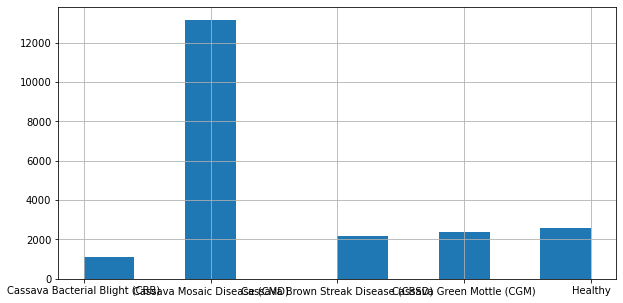

In [14]:
df['label'].hist(figsize = (10, 5))
plt.xticks(rotation='vertical')
plt.show()

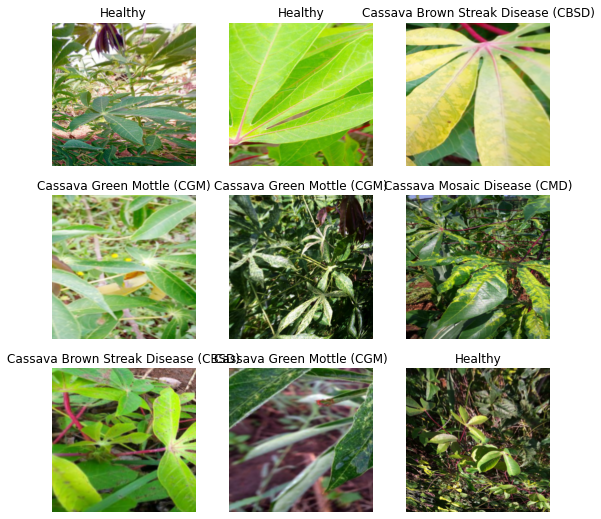

In [15]:
dls = ImageDataLoaders.from_df(df, path='cassava-leaf-disease-classification/', bs=bs,
                               item_tfms=Resize(320),
                               valid_col='valid',
                               batch_tfms=aug_transforms(size=sz,  mult=2, max_zoom=2.))
dls.show_batch()

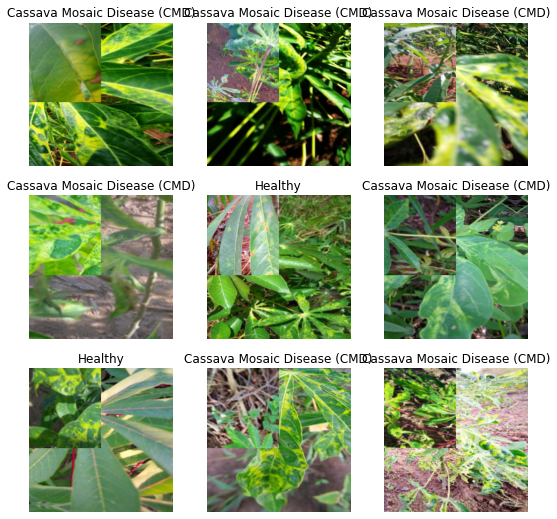

In [27]:
mixup = CutMix()
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.xb[0],mixup.y), ctxs=axs.flatten())

In [25]:
len(dls.vocab)

5

In [28]:
torch.cuda.empty_cache()

In [29]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=5)#len(dls.vocab))

Loaded pretrained weights for efficientnet-b3


In [19]:
#model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)

In [20]:
#model.classifier = nn.Linear(model.classifier.in_features, len(dls.vocab))

In [21]:
#model.load_state_dict(torch.load('timm-pretrained-efficientnet/efficientnet/tf_efficientnet_b3_ns-9d44bf68.pth'))

In [30]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), splitter=methodcaller('parameters'), metrics=accuracy)
learn.to_fp16()
learn.freeze()

In [31]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=5.248074739938602e-05)

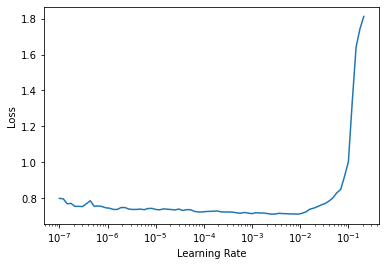

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.094631,1.380412,0.656929,03:26


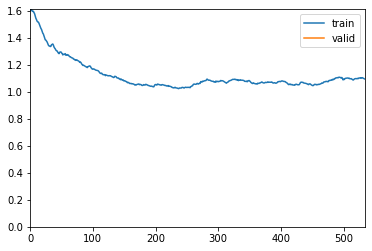

epoch,train_loss,valid_loss,accuracy,time
0,0.868407,0.761592,0.821454,03:27
1,0.872533,0.745953,0.826595,03:25
2,0.783687,0.699354,0.857677,03:28
3,0.778436,0.662001,0.873335,03:30
4,0.751714,0.635768,0.882917,03:29


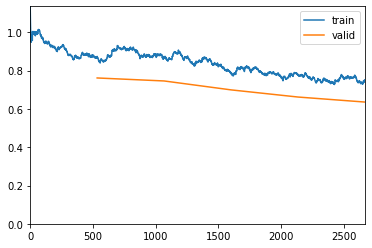

In [33]:
lr=3e-3
callback_lst=[ShowGraphCallback(), CutMix(), SaveModelCallback(monitor='accuracy', every_epoch=False, fname='AutoSave', with_opt=True)]
learn.fine_tune(epochs=5, base_lr=lr, cbs=callback_lst)

In [34]:
learn.load('AutoSave')

/home/stev/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [36]:
learn.save('Stage-1GPU')

Path('cassava-leaf-disease-classification/models/Stage-1GPU.pth')

In [38]:
learn.unfreeze()

In [ ]:
learn.lr_find() 

epoch,train_loss,valid_loss,accuracy,time
0,0.724515,0.636799,0.882449,03:34
1,0.729935,0.635509,0.882917,03:30
2,0.751082,0.635268,0.884319,03:28
3,0.734308,0.635184,0.883384,03:29
4,0.719487,0.635824,0.882917,03:25


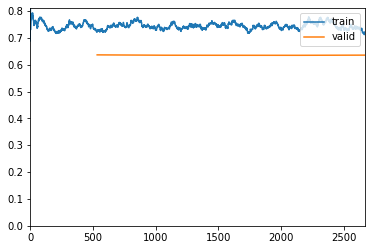

Better model found at epoch 0 with accuracy value: 0.8824491500854492.
Better model found at epoch 1 with accuracy value: 0.8829165697097778.
Better model found at epoch 2 with accuracy value: 0.8843187689781189.


In [42]:
lr=0.3e-5
learn.fit_one_cycle(n_epoch=5, lr_max=lr, wd=0.9, cbs=callback_lst)

In [44]:
learn.load('AutoSave')

In [45]:
learn.save('Stage-2GPU')

Path('cassava-leaf-disease-classification/models/Stage-2GPU.pth')

In [46]:
learn.freeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=6.309573450380412e-07)

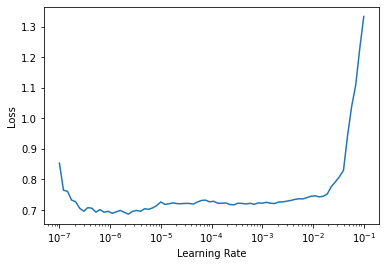

In [47]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.749526,0.635507,0.882215,03:28


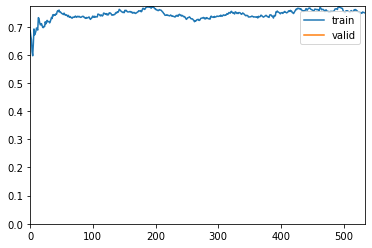

Better model found at epoch 0 with accuracy value: 0.8822154998779297.


epoch,train_loss,valid_loss,accuracy,time
0,0.732606,0.635776,0.882683,03:34
1,0.748386,0.636001,0.883150,03:38
2,0.736036,0.635750,0.883851,03:32
3,0.730216,0.635264,0.882449,03:29
4,0.731197,0.635130,0.882215,03:32


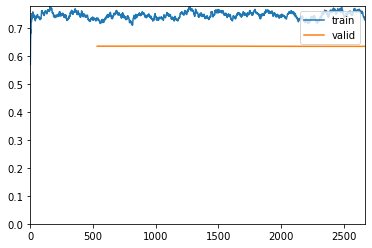

Better model found at epoch 0 with accuracy value: 0.8826828598976135.
Better model found at epoch 1 with accuracy value: 0.8831502795219421.
Better model found at epoch 2 with accuracy value: 0.8838513493537903.


In [48]:
lr=0.2e-7
learn.fine_tune(epochs=5, base_lr=lr, cbs=callback_lst)

In [23]:
dl = dls.valid
a1, target = learn.tta(dl=dl, n=16)
pred_1 = a1.argmax(dim=1)
(pred_1==target).to(float).mean()

TensorCategory(0.8981, dtype=torch.float64)

In [25]:
sample_df = pd.read_csv('cassava-leaf-disease-classification/sample_submission.csv')
sample_df.head()

,image_id,label
0,2216849948.jpg,4


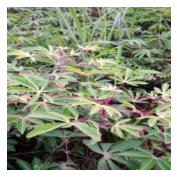

In [26]:
sample_copy = sample_df.copy()
sample_copy['image_id'] = sample_copy['image_id'].apply(lambda x: f'test_images/{x}')
test_dl = learn.dls.test_dl(sample_copy)
test_dl.show_batch()

In [27]:
a, _ = learn.tta(dl=test_dl, n=16)
pred = a.argmax(dim=1).numpy()
sample_df['label'] = pred

In [28]:
sample_df

,image_id,label
0,2216849948.jpg,2


In [ ]:
sample_df.to_csv('submission.csv',index=False)